In [357]:
import os 
from PIL import Image
import numpy as np

# Load images from a folder and return a list of images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('L')
        img = img.resize((64, 64))
        img_array = np.array(img).flatten() / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels


# Load the dataset from the given base path
def load_dataset(base_path):
    train_images, train_labels = [], []
    val_images, val_labels = [], []
    test_images, test_labels = [], []

    for dataset in ['train', 'val', 'test']:
        for label in ['PNEUMONIA', 'NORMAL']:
            folder = os.path.join(base_path, dataset, label)
            images, labels = load_images_from_folder(folder, label)
            if dataset == 'train':
                train_images.extend(images)
                train_labels.extend(labels)
            elif dataset == 'val':
                val_images.extend(images)
                val_labels.extend(labels)
            elif dataset == 'test':
                test_images.extend(images)
                test_labels.extend(labels)

    return (np.array(train_images), np.array(train_labels),
            np.array(val_images), np.array(val_labels),
            np.array(test_images), np.array(test_labels))

# Print the proportions of each label in the dataset
def print_label_proportions(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))
    total = len(labels)
    print(f"Proportions in {dataset_name} dataset:")
    for label, count in label_counts.items():
        proportion = (count / total) * 100
        print(f"  {label}: {proportion:.2f}% ({count}/{total})")


In [358]:
from sklearn.model_selection import train_test_split

base_path = './datasets/'
# Load the dataset
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_dataset(base_path)
# split
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.30, random_state=42)


In [359]:
print_label_proportions(train_labels, "train")
print_label_proportions(val_labels, "val")
print_label_proportions(test_labels, "test")

Proportions in train dataset:
  NORMAL: 27.42% (1121/4088)
  PNEUMONIA: 72.58% (2967/4088)
Proportions in val dataset:
  NORMAL: 50.00% (8/16)
  PNEUMONIA: 50.00% (8/16)
Proportions in test dataset:
  NORMAL: 25.91% (454/1752)
  PNEUMONIA: 74.09% (1298/1752)


In [360]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # Define the parameter grid
# param_grid = {
#     'C': [1.54, 1.55, 1.56],  # Tester des valeurs très proches de 1.55
#     'gamma': [0.001, 0.01],  # Tester des valeurs très proches de 0.015
#     'degree': [1]  # Garder degree à 1, car c'est le meilleur paramètre jusqu'à présent
# }

# grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
# grid_search.fit(train_images, train_labels)
# best_model = grid_search.best_estimator_

# # Prédire les étiquettes pour les données de test
# predictions = best_model.predict(test_images)

# # Calculer la précision du meilleur modèle
# precision = best_model.score(test_images, test_labels)
# print("Meilleurs paramètres:", grid_search.best_params_)
# print(f'Test Accuracy: {precision * 100:.2f}%')


In [361]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler


# Normaliser les données d'entraînement et de test avec StandardScaler
scaler = StandardScaler()
# Normaliser les données d'entraînement
train_images = scaler.fit_transform(train_images)
# Normaliser les données de test
test_images = scaler.transform(test_images)
# Créer et entraîner le classificateur SVM
clf = svm.SVC()
clf.fit(train_images, train_labels)
# Faire des prédictions avec les données de test
predictions = clf.predict(test_images)
# Calculer la précision du modèle
precision = clf.score(test_images, test_labels)
print(f'Test Accuracy: {precision * 100:.2f}%')

Test Accuracy: 95.89%


In [362]:
val_images = scaler.transform(val_images)
clf.predict(val_images)
precision = clf.score(val_images, val_labels)
print(f'Validation Accuracy: {precision * 100:.2f}%')

Validation Accuracy: 75.00%


Confusion Matrix:
[[ 414   40]
 [  32 1266]]


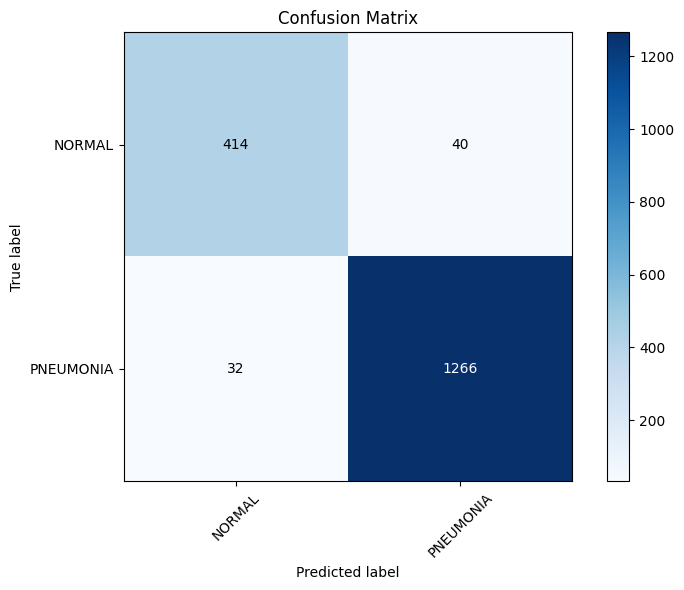

In [363]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_labels, predictions)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['NORMAL', 'PNEUMONIA'], rotation=45)
plt.yticks(tick_marks, ['NORMAL', 'PNEUMONIA'])

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [364]:
from sklearn.metrics import classification_report
target_names = ['NORMAL', 'PNEUMONIA']
print('Classification Report:')
print(classification_report(test_labels, predictions, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.91      0.92       454
   PNEUMONIA       0.97      0.98      0.97      1298

    accuracy                           0.96      1752
   macro avg       0.95      0.94      0.95      1752
weighted avg       0.96      0.96      0.96      1752



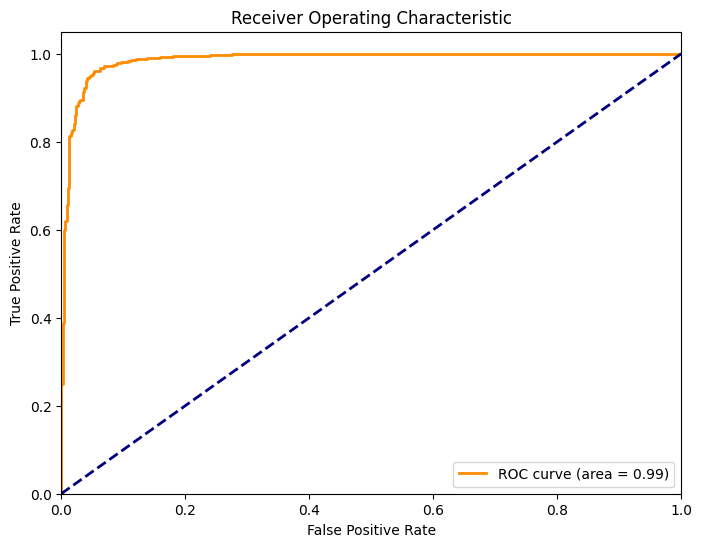

In [365]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get the decision function scores
test_scores = clf.decision_function(test_images)

# Compute ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_scores, pos_label='PNEUMONIA')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [366]:
import pickle
pickle.dump(clf, open('svm.pkl', 'wb'))